General information
===========

Source (organization): ESnet

Contacts: ESnet (Eric Pouyoul)

Time coverage: 8/1/2015 until 1/16/2016

Features type: TSTAT

Access control: public

Known users: X-SWAP


Overview
=====

This data set consists of [TSTAT](http://tstat.polito.it/) (TCP STatistic and Analysis Tool) data collected at NERSC Data Transfer Nodes (DTNs). The TSTAT tool captures network measurement data for both forward (from NERSC DTN) and backward (to NERSC DTN) stream of packets. TSTAT data is related to the traditional network flow data but differs because it is collected at the source endpoint. Due to this quality, TSTAT data is easier to correlate with other measurements performed on the hosts, such as application logs, I/O etc. The measurement data is collected in a set of text files where each row corresponds to a different flow and each column is associated to a specific measurement. More information about these files and specific measurements can be found [here](http://tstat.tlc.polito.it/measure.shtml#LOG). 

Access
====

The Kibana portal at NERSC can be accessed via the following url (https://kb.nersc.gov). Users need to have a NERSC NIM account to be able to access the data. 

Data Collection and Visualization
==================

The TSTAT measurement files are created periodically (by default every 5 minutes) on each DTN, and are processed every hour through a client software, [tstat-transport](https://github.com/esnet/tstat-transport), that converts the data into JSON objects and sends them to a RabbitMQ server. There is a [logstash](https://www.elastic.co/guide/en/logstash/current/introduction.html) instance running at NERSC that pulls the data from the RabbitMQ server, calculates additional measurements (like throughput, packets-retransmit% etc.), and ingests them into [Elasticsearch](https://www.elastic.co/guide/en/elasticsearch/reference/current/getting-started.html). NERSC provides a [Kibana](https://www.elastic.co/guide/en/kibana/current/introduction.html) portal to search and visualize the data from Elasticsearch.

In order to visualize TSTAT data, users need to select the appropriate Elasticsearch index, i.e., ** dtn-tstat-20* **. In order to generate graphs, users can click on the * Visualize * option and select the appropriate graph type. Additionally, users can also create a dashboard with a collection of multiple graphs by selecting the * Dashboard * option on the left menu.

If you do not get any result when selecting the dtn-tstat-2017, make sure that the time select is set to several years (top right). You should see something like the picture below:

<img src="tstat-elk-disco-1.png">


The following is a sample of a TSTAT record. A record contains several parts:

    ."meta": contains information related to the source and destination. Note that "sensor_id" contains the DNS name of the host from were the record is from, but src_ip and dst_ip can either be an IPv4, IPv6 or DNS name.
    ."geoip": geographical data of the measurement host
    ."values": contains mostly TCP related measurement
    

    @timestamp
    geoip.city_name
    geoip.continent_code
    geoip.country_code2
    geoip.country_code3
    geoip.country_name
    geoip.dma_code
    geoip.ip
    geoip.latitude
    geoip.location.lat
    geoip.location.lon
    geoip.longitude
    geoip.postal_code
    geoip.region_code
    geoip.region_name
    geoip.timezone

    meta.src_ip
    meta.dst_ip
    meta.dst_port
    meta.flow_type
    meta.instance_id
    meta.protocol
    meta.sensor_id
    meta.src_port

    source
    dest
    start
    end
    interval
    file_size_MB
    num_bytes
    percent_retrans
    throughput_Mbps

    values.bits_per_second
    values.duration
    values.num_bits
    values.num_packets
    values.packets_per_second
    values.tcp_cwin_max
    values.tcp_cwin_min
    values.tcp_initial_cwin
    values.tcp_max_seg_size
    values.tcp_min_seg_size
    values.tcp_mss
    values.tcp_out_seq_pkts
    values.tcp_pkts_dup
    values.tcp_pkts_fc
    values.tcp_pkts_fs
    values.tcp_pkts_reor
    values.tcp_pkts_rto
    values.tcp_pkts_unfs
    values.tcp_pkts_unk
    values.tcp_pkts_unrto
    values.tcp_rexmit_bytes
    values.tcp_rexmit_pkts
    values.tcp_rtt_avg
    values.tcp_rtt_max
    values.tcp_rtt_min
    values.tcp_rtt_std
    values.tcp_sack_cnt

    ndc.amqp_queue
    ndc.index_host
    ndc.index_time
    ndc.system
    ndc.type



Statistical Analysis
===========
In addition to the Kibana visualization, more sophisticated and complex statistical can also be done using the TSTAT data stored in Elasticsearch. We have developed an initial prototype that retrieves the data from Elasticsearch and allows users to perform complex queries and graph analysis on the data. It adds several aggregated columns and cleans the data prior to ingesting it in a MySQL database. This pre-processed data is then used for statistical analysis and building prediction models.

Similar frameworks or tools can be used to do statistical data analysis interactively through the interface. An example is shown below.

#### Sample Interface

Get the RTT values from TSTAT data for some endpoints.

In [1]:
# this is sample code quering the data set
import tstat_analyzer as analyzer

analyzer.get_rtt_values()

Site	Min	Max	StdDev	Avg
-------------------------------------
SLAC	0.001	2.158	0.007	0.006
ANL	47.68	97.985	5.876	54.175
BNL	70.699	110.908	9.996	74.17
ORNL	67.969	107.683	1.138	68.492


Retrieve network performance metrics for some NERSC DTNs.

In [2]:
analyzer.get_metrics()

Site	Tput	Rexmit%	WinScale
-------------------------------------
dtn01	4518.5	63.476	14
dtn05	4358.2	17.632	14
dtn08	6205.1	13.548	14
dtn10	4320.1	12.03	14


Using Jupyter with Elastic
==============


ELK is an excellent tool to vizualize and perform analytics. However, you require access to the ELK cluster, even to just vizualize the result of a pre-defined query. This sections describes how Jupyter can complement ELK when collarating on sensitive data set. 

Step 1: get data into Jupyter
---------------------------

ELK provides an API allowing search queries and analytics. There is a Python ELK client that can be used within Jupyter. The API is currently turned on but requires to configure and use a secured proxy at NERSC. This notebook will be expanded when this feature will be working. 

Using the ELK API, the user who is allowed to access the TSTAT data retrieves data set from the cluster and stores in either in memory or on a local file.

An alternative is to simply download the result of the ELK search as a json file.



In [3]:
import csv

def read_data_file():
    with open('data/data.csv') as f:
        first_row = False
        res = []
        for row in csv.reader(f): 
            if not first_row:
                first_row = True
                for col in row:
                    res.append([])
                continue
            index = 0
            for col in row:
                res[index].append(col)
                index += 1
    return res

In [4]:
data = read_data_file()
print "number of columns:",len(data)
print "number of rows:",len(data[0])

number of columns: 10
number of rows: 2175


Step 2: Process / Visualize
--------------------------

In [17]:
def sort_by_destination(data):
    nb_cols = len(data)
    res = {}
    index = 0
    for dst in data[1]:
        if not dst in res:
            res[dst] = []
            for i in range(nb_cols):
                res[dst].append([])
                
        for col in range(nb_cols):
            res[dst][col].append(data[col][index])
        index += 1
    return res


In [19]:
by_dest = sort_by_destination(data)
print "number of destinations:", len(by_dest)

number of destinations: 165


<IPython.core.display.Javascript object>


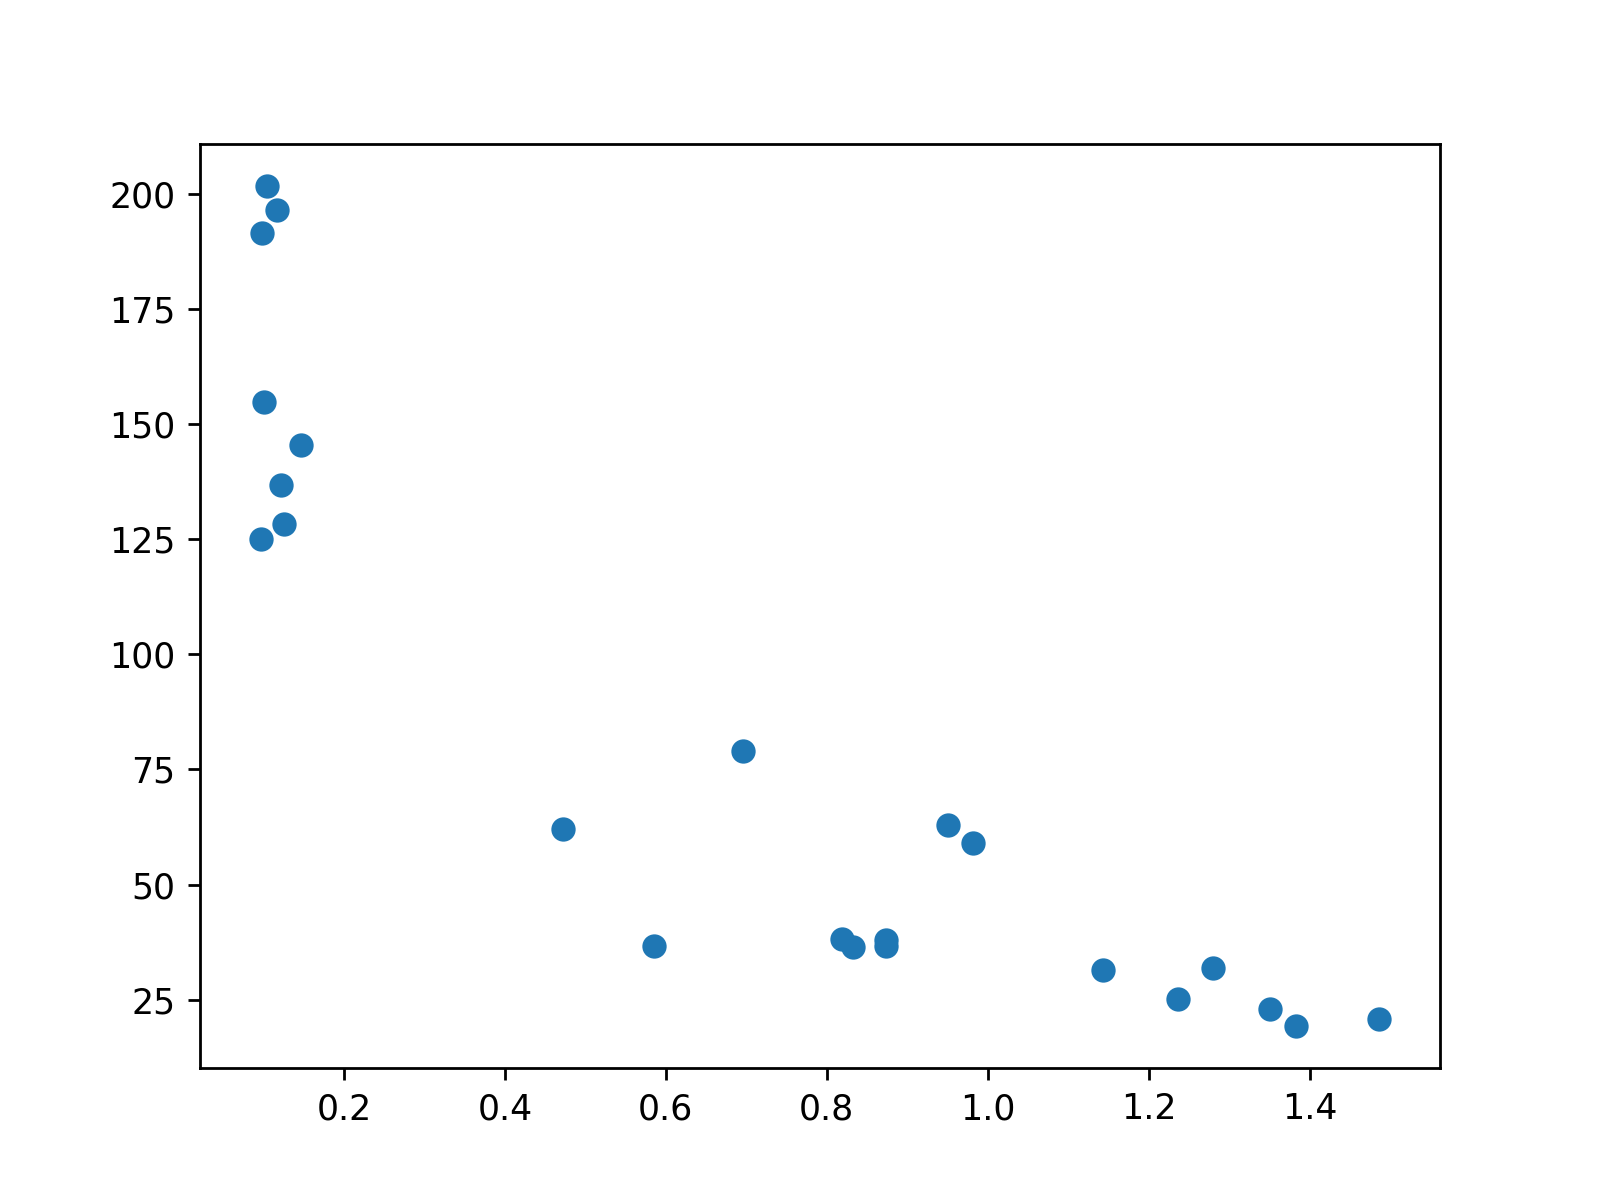

In [21]:
# needs  $ conda install -c conda-forge bqplot
%gui osx
%matplotlib notebook
import numpy as np

from IPython.display import display

import matplotlib.pyplot as plt

import bqplot.pyplot as bplt
from bqplot import LinearScale
from bqplot import Axis

def plot_dest(row, dest, x_index, y_index):
    plot = plt.scatter(row[x_index],row[y_index],label=dest)
    return plot

plot = plot_dest(by_dest['gridftp01.ucar.edu'],'gridftp01.ucar.edu',5,9)
#plt.show()

Results, issues, filtering, pre-processing
=======================

It is important to note that TSTAT data is mostly useful if collected at the source of the flows. In other words, data that are received from other DTN can be filtered out.
